# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.models.detection import fcos
from torchvision.transforms import v2 as v2
from tqdm.auto import tqdm, trange

import bb
import models
import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

SEED = 325
tt.seed(SEED)

In [ ]:
DATA_PATH = Path.home() / "src/data"
CKPT_ROOT = DATA_PATH / "checkpoints"
BATCH_SIZE = 16
TRAIN_PCT = .85
TRANSFORM = v2.Compose(
    [
        # Geometric transforms
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomAffine(
            degrees=5,
            translate=(0.1, 0.1),
            scale=(0.5, 1.5),
            shear=0,
        ),
        v2.RandomPerspective(distortion_scale=0.1, p=0.5),
        # Color transforms
        v2.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.01,
        ),
        # Cleanup after geometric transforms
        v2.ClampBoundingBoxes(),
        v2.SanitizeBoundingBoxes(min_size=10, min_area=100),
    ]
)

MCD_ROOT = DATA_PATH / "coco/minecraft"
MCD = bb.MCDataset(MCD_ROOT)
TRAIN_DSET, VALID_DSET = tt.split1(MCD, TRAIN_PCT, SEED)
TRAIN_DSET = bb.TransformedSubset(TRAIN_DSET, TRANSFORM)

TRAIN_LOADER = DataLoader(
    TRAIN_DSET,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
VAL_LOADER = DataLoader(
    VALID_DSET,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(TRAIN_DSET)}, n_valid={len(VALID_DSET)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62


# Utils

In [ ]:
def show_batch_preds(
    trainer: models.FCOSTrainer,
    data_loader: DataLoader,
    k: int = 5,
    thresh: float = 0.5,
) -> Image.Image:
    images, targets = next(iter(data_loader))
    preds = trainer.forward(images)
    lens = [len(p["scores"]) for p in preds]
    print(f"Preds lengths: {lens}")
    preds = trainer.filter_preds(preds, thresh=thresh)
    preds = trainer.topk_preds(preds, k=k)
    return bb.plot_bb_grid(images, preds, AUG_MCD.categories, include_scores=True, nrow=2)

# Experiment Log

## Experiments

### exp1 - classification head only, He init
- cls_head_only_he_init_10ep.pt
- 10 epochs, lr=1e-4
- mAP: 0.0014
- loss looked great, detections terrible

### exp2 - classification head only, FCOS init  
- cls_head_only_fcos_init_8ep.pt
- 10 epochs, lr=1e-4
- mAP: 0.0554
- loss looked worse but 40x better mAP

### exp3 - full head unfrozen, FCOS init
- lr=1e-4
- 10 epochs - mAP: 0.2784 - full_head_10ep.pt
- 20 epochs - mAP: 0.3189 - full_head_20ep.pt
- 40 epochs - mAP: 0.3511 - full_head_40ep.pt
- 50 epochs - mAP: 0.3235 - full_head_50ep.pt
- Much better

### exp4 - full head unfrozen, He init
- mAP - 0.0013
- 10 epochs, lr=1e-4
- Still bad

### exp5 - full head unfrozen, FCOS init, lr=1e-3
- lr=1e-3
- 20 epochs - mAP: 0.3208 - full_head_lr3_20ep.pt
- 40 epochs - mAP: 0.3264 - full_head_lr3_40ep.pt

### Future experiments are all FCOS init

### exp6 - full head unfrozen, aug
 - v2.RandomHorizontalFlip(p=0.5), ColorJitter(brightness=0.2, contrast=0.2),
 - 20 epochs - lr=1e-4 mAP=0.2906 - aug_lr4_20ep.pt
 - 40 epochs - switch to lr=5e-4 loss=0.7192 mAP=0.3307 - aug_lr4_40ep.pt

### exp7 - manually var lr
- lr 1e-3 for 10, lr 1e-4 for 20, lr 5e-5 for 10
- epochs=10 loss=1.0806 mAP=0.2636
- epochs=30 loss=0.8719 mAP=0.3528
- epochs=40 loss=0.7976 mAP=0.3608

### exp8 - ReduceLROnPlateau
- Final epochs=40 loss=0.7257 mAP=0.3546

### exp9 - ReduceLROnPlateau - same with save best
- New best mAP=0.3566 at epoch 31
- Final epochs=60 loss=0.6600 mAP=0.3351

### exp10 - CosineAnnealingWarmRestarts
- T_0=20
- New best mAP=0.3868 at epoch 39
- Final epochs=60 loss=0.8090 mAP=0.3674

### exp11 - CosineAnnealing
- T_max=60
- New best mAP=0.3931 at epoch 54
- Final epochs=60 loss=0.7302 mAP=0.3773

### exp12 - CosineAnnealing, plus nms_thresh=0.2
- T_max=60
- New best mAP=0.3736 at epoch 60
- Epoch 60: val mAP=0.3736 lr=0.000001

### exp13 - like exp12 but added new augmentations
- New best mAP=0.4305 at epoch 57           * Best
- Validation was done with transformed images

### exp14 - like exp13 but fixed validation
- New best mAP=0.4132 at epoch 56
- Final epochs=60 loss=1.0941 mAP=0.4000

### exp15 - like exp14 but 100 epochs


# Experiments

## Exp 1

In [ ]:
he_init_ckpt = CKPT_ROOT / f"cls_head_only_he_init_{NUM_EPOCHS}ep.pt"

# e_he_init = models.FCOSTrainer(categories=mcd.categories, he_init=True)
# e_he_init.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# e_he_init.save_checkpoint(he_init_ckpt)

# e_he_init = models.FCOSTrainer(
#     categories=mcd.categories, he_init=True, checkpoint=he_init_ckpt
# )

## Exp 2

In [ ]:
fcos_init_ckpt = CKPT_ROOT / f"cls_head_only_fcos_init_{NUM_EPOCHS}ep.pt"

# e_fcos_init = models.FCOSTrainer(categories=mcd.categories, he_init=False)
# e_fcos_init.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# e_fcos_init.save_checkpoint(fcos_init_ckpt)

# e_fcos_init = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=fcos_init_ckpt
# )

## Exp 3

In [ ]:
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, he_init=False)
START_CKPT = CKPT_ROOT / f"full_head_40ep.pt"
END_CKPT = CKPT_ROOT / f"full_head_50ep.pt"

# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(CKPT)

TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=START_CKPT
)
TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=10)
TRAINER.save_checkpoint(END_CKPT)

# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
TRAINER.plot_loss(label="Exp 3")
TRAINER.plot_eval(label="Exp 3")

In [ ]:
epoch_range = (30, None)
TRAINER.plot_loss(epoch_range=epoch_range, show=True)
TRAINER.plot_eval(epoch_range=epoch_range)

## Exp 5

In [ ]:
start_epoch = 20
end_epoch = 40
NUM_EPOCHS = end_epoch - start_epoch
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, he_init=False)
START_CKPT = CKPT_ROOT / f"full_head_lr3_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"full_head_lr3_{end_epoch}ep.pt"

# Train new
# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=START_CKPT
# )
# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=END_CKPT
)
TRAINER.plot_loss(label="Exp 5")
TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, VAL_LOADER, k=5)

In [ ]:
epoch_range = (-20, None)
TRAINER.plot_loss(epoch_range=epoch_range, show=True)
TRAINER.plot_eval(epoch_range=epoch_range)

## Exp 6

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 20
end_epoch = 40
LR = 1e-4
epoch_prefix = "aug_lr4"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None
# bb.plot_bb_grid(images, targets, mcd.categories)

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, he_init=False, lr=LR)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
LR = 5e-5
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=START_CKPT, lr=LR
)
TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
TRAINER.save_checkpoint(END_CKPT)

# Load and plot
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
# TRAINER.plot_loss(label="Exp 5")
# TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, aug_val_loader, k=5)

## Exp 7

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 30
end_epoch = 40
epoch_prefix = "exp7"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# LR = 1e-3
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, he_init=False, lr=LR)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# LR = 1e-4
LR = 5e-5
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=START_CKPT, lr=LR
)
TRAINER.train(
    train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
)
TRAINER.save_checkpoint(END_CKPT)

# Load and plot
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
# TRAINER.plot_loss(label="Exp 5")
# TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, aug_val_loader, k=1)

## Exp 8

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 40
end_epoch = 60
epoch_prefix = "exp8"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"
BEST_CKPT = CKPT_ROOT / f"{epoch_prefix}_best.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=START_CKPT)
# TRAINER.train(
#     train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
# )
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, load_checkpoint=END_CKPT)
TRAINER.plot_loss(label="Exp 8", show=True)
TRAINER.plot_eval(label="Exp 8")

## Exp9

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 0
end_epoch = 60
epoch_prefix = "exp9"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"
BEST_CKPT = CKPT_ROOT / f"{epoch_prefix}_best.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, best_checkpoint=BEST_CKPT)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=START_CKPT, best_checkpoint=BEST_CKPT)
# TRAINER.train(
#     train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
# )
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, load_checkpoint=END_CKPT)
TRAINER.plot_loss(label=epoch_prefix, show=True)
TRAINER.plot_eval(label=epoch_prefix)

In [ ]:

# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
trainer = models.FCOSTrainer(categories=AUG_MCD.categories, load_checkpoint=BEST_CKPT)
show_batch_preds(trainer, VAL_LOADER, k=1)

## Exp10

In [ ]:
project = "exp10"
num_epochs = 60
load_chkpt = "best.pt"

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, project_dir=project_dir, load_checkpoint=load_chkpt
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)

## Exp11

In [ ]:
project = "exp11"
num_epochs = 60
load_chkpt = "best.pt"

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, project_dir=project_dir, load_checkpoint=load_chkpt
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)

## Exp12

In [ ]:
project = "exp12"
num_epochs = 60
load_chkpt = None

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
TRAINER.save_checkpoint()

# Plot
# TRAINER.plot_loss(label=project, show=True)
# TRAINER.plot_eval(label=project, show=True)
# TRAINER.plot_lr(label=project)

## Exp13

Loading checkpoint: /Users/joe/src/data/checkpoints/exp13/best.pt
err_keys = <All keys matched successfully>


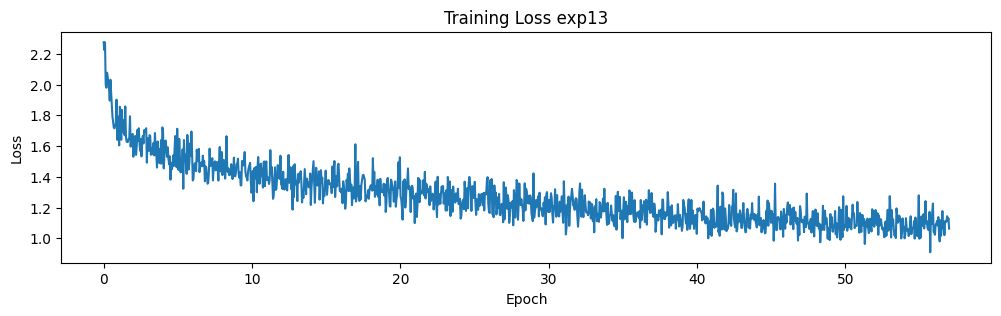

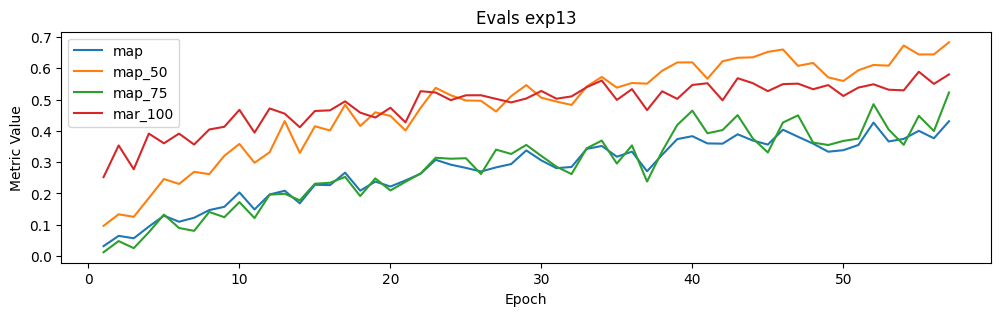

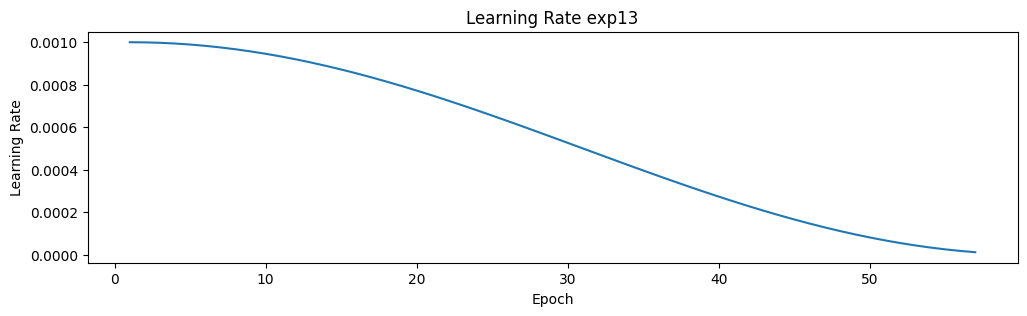

In [ ]:
project = "exp13"
num_epochs = 60
load_chkpt = "best.pt"

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)

In [ ]:
TRAINER.evaluate(VAL_LOADER)

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

{'map': tensor(0.4223),
 'map_50': tensor(0.6678),
 'map_75': tensor(0.4765),
 'map_small': tensor(0.),
 'map_medium': tensor(0.2865),
 'map_large': tensor(0.4819),
 'mar_1': tensor(0.5085),
 'mar_10': tensor(0.5493),
 'mar_100': tensor(0.5493),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.4776),
 'mar_large': tensor(0.5816),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=torch.int32)}

## Exp14

Initializing new model
err_keys = _IncompatibleKeys(missing_keys=['head.classification_head.cls_logits.weight', 'head.classification_head.cls_logits.bias'], unexpected_keys=[])


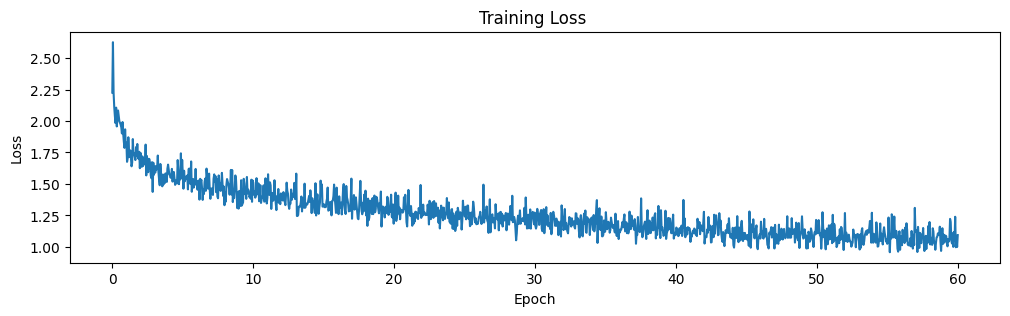

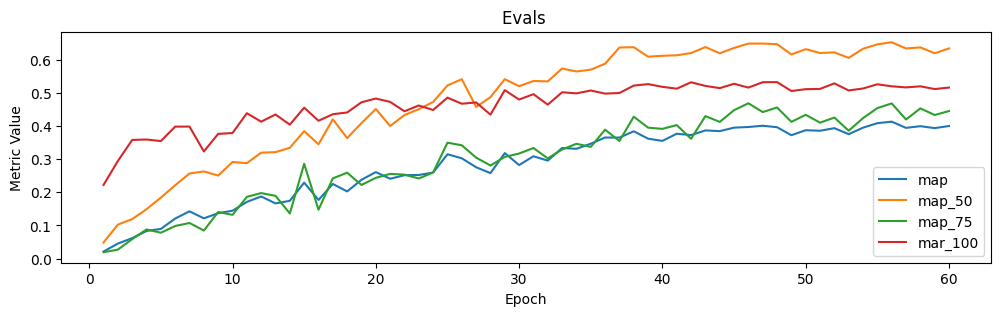

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0211 at epoch 1
Epoch 1: val mAP=0.0211 lr=0.001000


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0451 at epoch 2
Epoch 2: val mAP=0.0451 lr=0.000999


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0615 at epoch 3
Epoch 3: val mAP=0.0615 lr=0.000997


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0832 at epoch 4
Epoch 4: val mAP=0.0832 lr=0.000994


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0893 at epoch 5
Epoch 5: val mAP=0.0893 lr=0.000989


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1207 at epoch 6
Epoch 6: val mAP=0.1207 lr=0.000983


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1425 at epoch 7
Epoch 7: val mAP=0.1425 lr=0.000976


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: val mAP=0.1213 lr=0.000967


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: val mAP=0.1369 lr=0.000957


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1444 at epoch 10
Epoch 10: val mAP=0.1444 lr=0.000946


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1709 at epoch 11
Epoch 11: val mAP=0.1709 lr=0.000933


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1873 at epoch 12
Epoch 12: val mAP=0.1873 lr=0.000919


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: val mAP=0.1664 lr=0.000905


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: val mAP=0.1742 lr=0.000889


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2291 at epoch 15
Epoch 15: val mAP=0.2291 lr=0.000872


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: val mAP=0.1768 lr=0.000854


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: val mAP=0.2251 lr=0.000835


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: val mAP=0.2025 lr=0.000815


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2377 at epoch 19
Epoch 19: val mAP=0.2377 lr=0.000794


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2609 at epoch 20
Epoch 20: val mAP=0.2609 lr=0.000772


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21: val mAP=0.2409 lr=0.000750


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22: val mAP=0.2515 lr=0.000727


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23: val mAP=0.2522 lr=0.000703


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24: val mAP=0.2595 lr=0.000679


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3147 at epoch 25
Epoch 25: val mAP=0.3147 lr=0.000655


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26: val mAP=0.3025 lr=0.000629


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27: val mAP=0.2755 lr=0.000604


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28: val mAP=0.2578 lr=0.000578


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3183 at epoch 29
Epoch 29: val mAP=0.3183 lr=0.000552


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30: val mAP=0.2822 lr=0.000526


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31: val mAP=0.3087 lr=0.000500


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32: val mAP=0.2956 lr=0.000474


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3337 at epoch 33
Epoch 33: val mAP=0.3337 lr=0.000448


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34: val mAP=0.3312 lr=0.000422


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3465 at epoch 35
Epoch 35: val mAP=0.3465 lr=0.000396


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3653 at epoch 36
Epoch 36: val mAP=0.3653 lr=0.000371


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37: val mAP=0.3650 lr=0.000345


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3841 at epoch 38
Epoch 38: val mAP=0.3841 lr=0.000321


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39: val mAP=0.3618 lr=0.000297


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40: val mAP=0.3551 lr=0.000273


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41: val mAP=0.3767 lr=0.000250


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42: val mAP=0.3726 lr=0.000228


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3867 at epoch 43
Epoch 43: val mAP=0.3867 lr=0.000206


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44: val mAP=0.3845 lr=0.000185


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3951 at epoch 45
Epoch 45: val mAP=0.3951 lr=0.000165


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3970 at epoch 46
Epoch 46: val mAP=0.3970 lr=0.000146


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.4008 at epoch 47
Epoch 47: val mAP=0.4008 lr=0.000128


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48: val mAP=0.3965 lr=0.000111


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49: val mAP=0.3722 lr=0.000095


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50: val mAP=0.3873 lr=0.000081


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51: val mAP=0.3858 lr=0.000067


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52: val mAP=0.3935 lr=0.000054


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53: val mAP=0.3754 lr=0.000043


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54: val mAP=0.3950 lr=0.000033


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.4086 at epoch 55
Epoch 55: val mAP=0.4086 lr=0.000024


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.4132 at epoch 56
Epoch 56: val mAP=0.4132 lr=0.000017


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57: val mAP=0.3944 lr=0.000011


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58: val mAP=0.3995 lr=0.000006


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59: val mAP=0.3936 lr=0.000003


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60: val mAP=0.4000 lr=0.000001
Final epochs=60 loss=1.0941 mAP=0.4000


In [ ]:
project = "exp14"
num_epochs = 60
load_chkpt = None

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
TRAINER.save_checkpoint()

# Plot
# TRAINER.plot_loss(label=project, show=True)
# TRAINER.plot_eval(label=project, show=True)
# TRAINER.plot_lr(label=project)

## Exp15

Initializing new model
err_keys = _IncompatibleKeys(missing_keys=['head.classification_head.cls_logits.weight', 'head.classification_head.cls_logits.bias'], unexpected_keys=[])


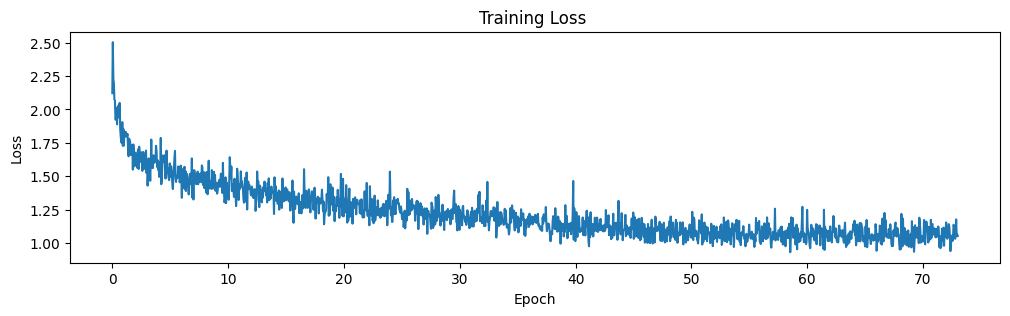

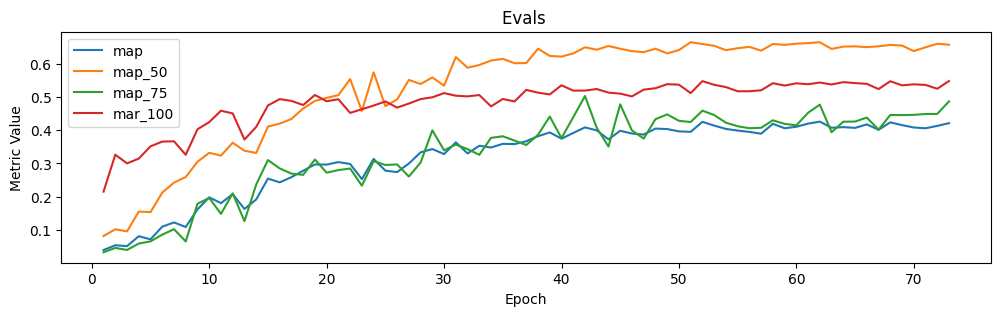

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0399 at epoch 1
Epoch 1: val mAP=0.0399 lr=0.001000


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0542 at epoch 2
Epoch 2: val mAP=0.0542 lr=0.000999


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: val mAP=0.0516 lr=0.000997


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.0814 at epoch 4
Epoch 4: val mAP=0.0814 lr=0.000994


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: val mAP=0.0721 lr=0.000989


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1102 at epoch 6
Epoch 6: val mAP=0.1102 lr=0.000983


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1228 at epoch 7
Epoch 7: val mAP=0.1228 lr=0.000976


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: val mAP=0.1092 lr=0.000967


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1621 at epoch 9
Epoch 9: val mAP=0.1621 lr=0.000957


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.1983 at epoch 10
Epoch 10: val mAP=0.1983 lr=0.000946


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: val mAP=0.1808 lr=0.000933


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2079 at epoch 12
Epoch 12: val mAP=0.2079 lr=0.000919


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: val mAP=0.1633 lr=0.000905


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: val mAP=0.1918 lr=0.000889


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2546 at epoch 15
Epoch 15: val mAP=0.2546 lr=0.000872


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: val mAP=0.2433 lr=0.000854


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2589 at epoch 17
Epoch 17: val mAP=0.2589 lr=0.000835


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2782 at epoch 18
Epoch 18: val mAP=0.2782 lr=0.000815


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.2972 at epoch 19
Epoch 19: val mAP=0.2972 lr=0.000794


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: val mAP=0.2967 lr=0.000772


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3042 at epoch 21
Epoch 21: val mAP=0.3042 lr=0.000750


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22: val mAP=0.2984 lr=0.000727


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23: val mAP=0.2530 lr=0.000703


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3137 at epoch 24
Epoch 24: val mAP=0.3137 lr=0.000679


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25: val mAP=0.2784 lr=0.000655


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26: val mAP=0.2741 lr=0.000629


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27: val mAP=0.2998 lr=0.000604


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3336 at epoch 28
Epoch 28: val mAP=0.3336 lr=0.000578


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3434 at epoch 29
Epoch 29: val mAP=0.3434 lr=0.000552


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30: val mAP=0.3283 lr=0.000526


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3636 at epoch 31
Epoch 31: val mAP=0.3636 lr=0.000500


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32: val mAP=0.3302 lr=0.000474


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33: val mAP=0.3533 lr=0.000448


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34: val mAP=0.3481 lr=0.000422


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35: val mAP=0.3591 lr=0.000396


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36: val mAP=0.3583 lr=0.000371


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3668 at epoch 37
Epoch 37: val mAP=0.3668 lr=0.000345


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3819 at epoch 38
Epoch 38: val mAP=0.3819 lr=0.000321


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.3934 at epoch 39
Epoch 39: val mAP=0.3934 lr=0.000297


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40: val mAP=0.3746 lr=0.000273


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41: val mAP=0.3918 lr=0.000250


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.4085 at epoch 42
Epoch 42: val mAP=0.4085 lr=0.000228


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43: val mAP=0.3996 lr=0.000206


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44: val mAP=0.3725 lr=0.000185


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45: val mAP=0.3984 lr=0.000165


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46: val mAP=0.3900 lr=0.000146


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47: val mAP=0.3870 lr=0.000128


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48: val mAP=0.4049 lr=0.000111


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49: val mAP=0.4035 lr=0.000095


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50: val mAP=0.3966 lr=0.000081


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51: val mAP=0.3951 lr=0.000067


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.4252 at epoch 52
Epoch 52: val mAP=0.4252 lr=0.000054


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53: val mAP=0.4139 lr=0.000043


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54: val mAP=0.4040 lr=0.000033


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55: val mAP=0.3989 lr=0.000024


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56: val mAP=0.3950 lr=0.000017


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57: val mAP=0.3895 lr=0.000011


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58: val mAP=0.4192 lr=0.000006


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59: val mAP=0.4059 lr=0.000003


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60: val mAP=0.4104 lr=0.000001


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61: val mAP=0.4199 lr=0.000000


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

New best mAP=0.4258 at epoch 62
Epoch 62: val mAP=0.4258 lr=0.000001


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63: val mAP=0.4074 lr=0.000003


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64: val mAP=0.4093 lr=0.000006


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65: val mAP=0.4070 lr=0.000011


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66: val mAP=0.4176 lr=0.000017


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67: val mAP=0.4013 lr=0.000024


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68: val mAP=0.4236 lr=0.000033


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69: val mAP=0.4153 lr=0.000043


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70: val mAP=0.4082 lr=0.000054


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71: val mAP=0.4058 lr=0.000067


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72: val mAP=0.4130 lr=0.000081


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73: val mAP=0.4213 lr=0.000095


Batch:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
project = "exp15"
num_epochs = 100
load_chkpt = None

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
TRAINER.save_checkpoint()

# Plot
# TRAINER.plot_loss(label=project, show=True)
# TRAINER.plot_eval(label=project, show=True)
# TRAINER.plot_lr(label=project)

# Scratch

In [ ]:
dir(VALID_DSET)

In [ ]:
img_ix = 20
TRAINER.plot_infer(VALID_DSET[img_ix][0], topk=5)

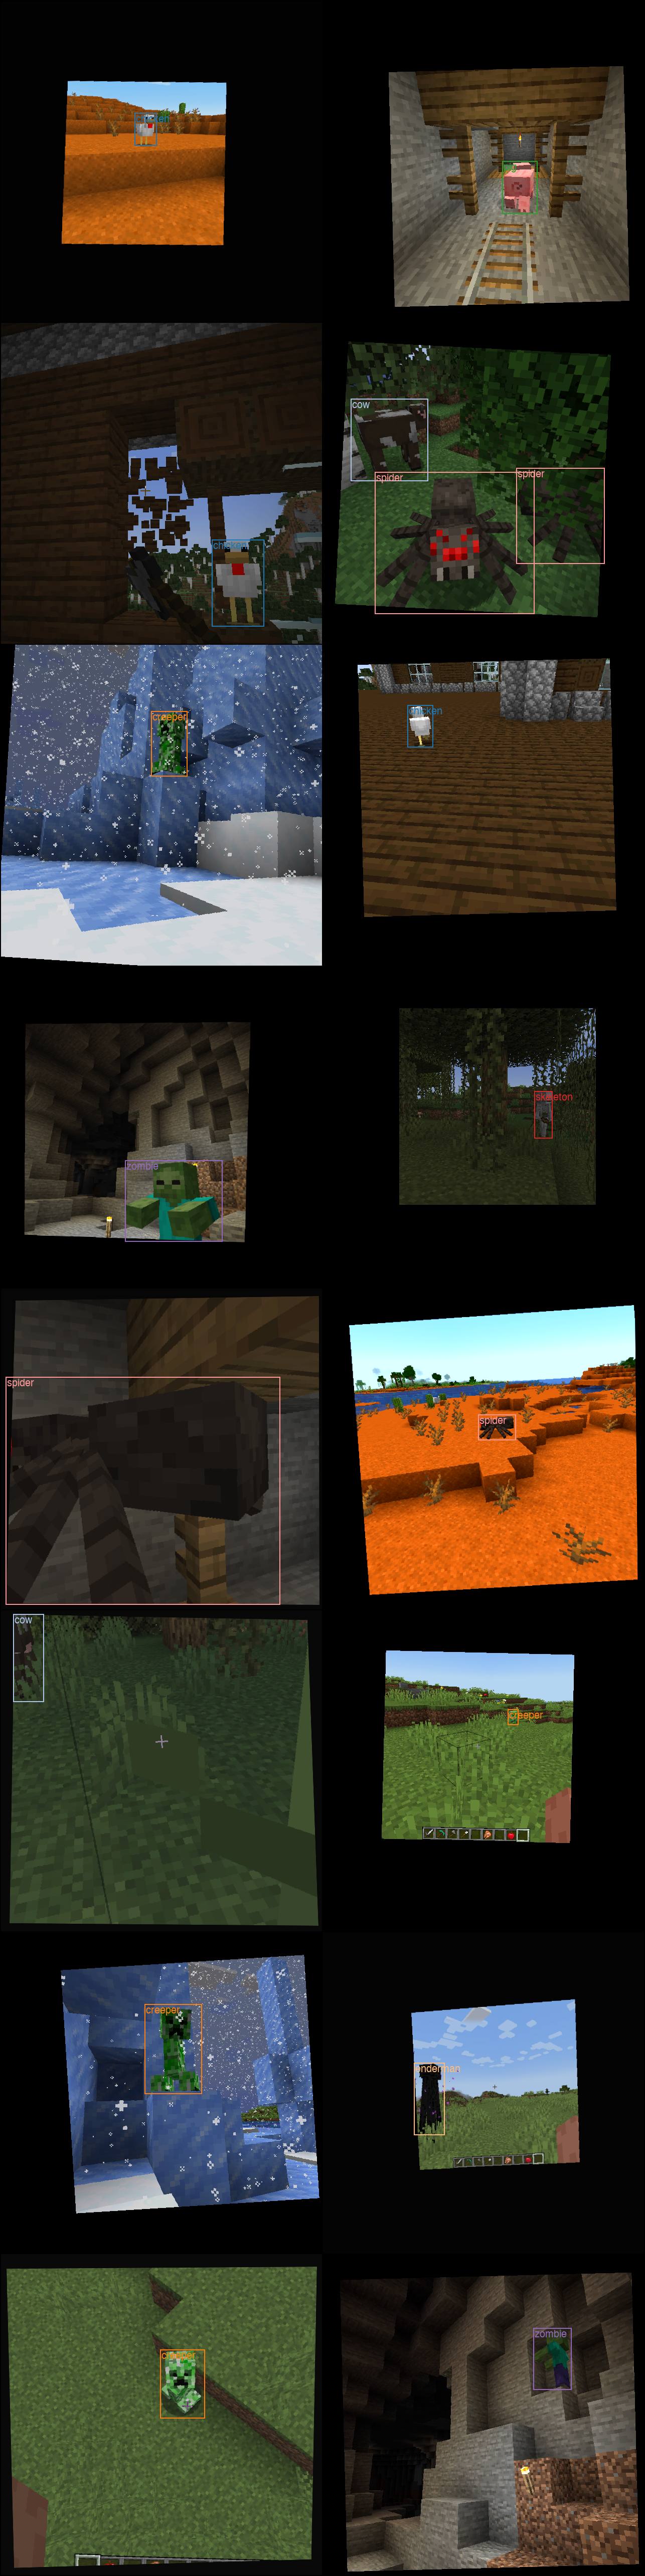

In [ ]:
# images, targets = next(iter(VAL_LOADER))
images, targets = next(iter(TRAIN_LOADER))
bb.plot_bb_grid(images, targets, MCD.categories, nrow=2)

In [ ]:
show_batch_preds(TRAINER, VAL_LOADER, k=5)

# Augmentation tests

In [ ]:
transform = v2.Compose(
    [
        # Geometric transforms
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomAffine(
            degrees=5,
            translate=(0.1, 0.1),
            scale=(0.5, 1.5),
            shear=0,
        ),
        v2.RandomPerspective(distortion_scale=0.1, p=0.5),
        # Color transforms
        v2.ColorJitter(
            brightness=0.4,
            contrast=0.2,
            saturation=0.7,
            hue=0.01,
        ),
        # Cleanup after geometric transforms
        v2.ClampBoundingBoxes(),
        v2.SanitizeBoundingBoxes(min_size=1),
    ]
)

In [ ]:
image, target = MCD[0]

# Apply to image and boxes together
image, target = transform(image, target)
print(image.shape)
# Fv2.to_pil_image(image)
bb.torch_plot_bb(image, target, categories=MCD.categories, return_pil=True)